# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [ ]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [ ]:

#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

## **Data Exploration**

**1. Portfolio Dataset**

In [ ]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [ ]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [ ]:
#chechking if the data is missing
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

There is no null values, and the dataset includes 10 types of offers

In [ ]:
# Offers of each type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

There are 3 offers' categories: bogo, discount and informational. Each one is then subcategorized based on other feature such as duration difficulty

In [ ]:
#types of channels
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

There are 4 channels: web, email, mobile, social. It is better to divise this column into 4 columns where values are 0 or 1.

**2. Profile Dataset**

In [ ]:
profile.shape

(17000, 5)

In [ ]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [ ]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [ ]:
#checking missing values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

There is 2175 null values in gender and icome

In [ ]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


As we can notice in the age column, the maximum is 118 which is a wrong value.
In the next cell we will check rows where the age 118 figures

In [ ]:
profile[profile['age']==118]

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [ ]:
profile[profile['age']==118].isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

We notice here that all the rows with the wrong age value have null values in both gender and income. We then drop and clean these rows

In [ ]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

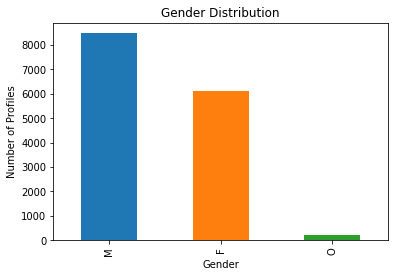

In [ ]:
ax = profile.gender.value_counts()
ax.plot(kind='bar')
plt.ylabel('Number of Profiles')
plt.xlabel('Gender')
plt.title('Gender Distribution');

profile users are more man than female, whereas others represent a small sample of our data

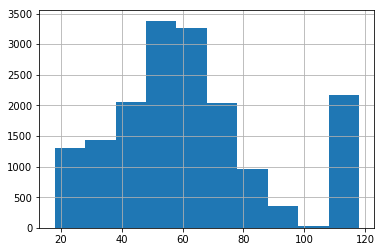

In [ ]:
# distribution of ages
profile.age.hist();

The majority of users are between the age of 40 and 75

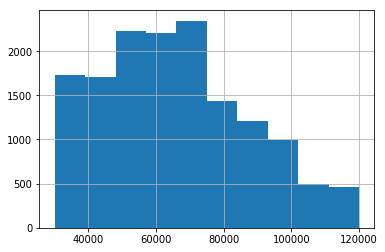

In [ ]:
# distribution of income
profile.income.hist();

Incomes vary between 20000 and 120000 but most users get between 50000 and 75000

**3. Transcript Dataset**

In [ ]:
transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [ ]:
transcript.shape

(306534, 4)

In [ ]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [ ]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

There is no missing values

In [ ]:
transcript.event.nunique()

4

we can see here that there are 4 types of events. let's check them

In [ ]:
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

## **Data Cleaning**

We first need to make a copy of each dataset

In [ ]:
df_profile=profile.copy()
df_transcript=transcript.copy()
df_portfolio=portfolio.copy()

### Portfolio dataset

#### 1.convert the column 'Channels' into 4 different channel on the basis of different types of channel .

In [ ]:
#create dummy variable
dummy = pd.get_dummies(df_portfolio.channels.apply(pd.Series).stack()).sum(level=0)
df_portfolio = pd.concat([df_portfolio, dummy], axis=1)
df_portfolio = df_portfolio.drop(columns='channels')

In [ ]:
df_portfolio.head(2)

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1


#### 2. change the column name id to more significant name: offer_id

In [ ]:
df_portfolio.rename(columns= {'id':'offer_id'}, inplace=True)

### Profile dataset

In [ ]:
df_wrongAge = df_profile[df_profile['age']==118]

#### 1. Data not Valid: Dropping rows where where age >118

In [ ]:
df_profile.drop(df_wrongAge.index, axis=0, inplace=True)

In [ ]:
#test the clean dataset
df_profile[df_profile['age']==118].count()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [ ]:
df_profile.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


#### 2. Invalid data type for became_member_on : Convert this column to date type

#### code

In [ ]:
df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d')

#### test

In [ ]:
df_profile.dtypes

age                          int64
became_member_on    datetime64[ns]
gender                      object
id                          object
income                     float64
dtype: object

#### 3. change the column name id to more significant name: customer_id

#### code

In [ ]:
df_profile.rename(columns= {'id':'customer_id'}, inplace=True)

#### test

In [ ]:
df_profile.head(1)

,age,became_member_on,gender,customer_id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0


### Transcript dataset

In [ ]:
df_transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [ ]:
df_transcript['value']

0          {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2          {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3          {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4          {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5          {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6          {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7          {'offer id': '3f207df678b143eea3cee63160fa8bed'}
8          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
10         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
11         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
12         {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
13         {'offer id': '3f207df678b143eea3cee63160fa8bed'}
14         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
15         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
16         {'offer id': '0b1e1539f2cc45b

#### 1. Change the column's name person to a more significant name: customer_id

#### code

In [ ]:
df_transcript = df_transcript.rename(columns={'person':'customer_id'})

#### test

In [ ]:
df_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event          306534 non-null object
customer_id    306534 non-null object
time           306534 non-null int64
value          306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


#### 2. convert the column 'Values' into 2 different columns and drop value column

#### code

In [ ]:
# Functions to create offer id and amount columns
def create_offer_id_column(value):
    if list(value.keys())[0] in ['offer id', 'offer_id']:
        return list(value.values())[0]
    
def create_amount_column(value):
    if list(value.keys())[0] in ["amount"]:
        return list(value.values())[0]

In [ ]:
df_transcript['offer_id'] = df_transcript.value.apply(create_offer_id_column)
df_transcript['amount'] = df_transcript.value.apply(create_amount_column)

In [ ]:
# drop value column
df_transcript.drop(columns='value',inplace=True)

#### test

In [ ]:
df_transcript.head(1)

,event,customer_id,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN


#### 3. convert the column 'Event' into 4 different columns on the basis of different types of event .

#### code

In [ ]:
dummy = pd.get_dummies(df_transcript['event'])
df_transcript = pd.concat([df_transcript, dummy], axis=1)
df_transcript.drop(columns='event',inplace=True)

#### test

In [ ]:
df_transcript.head(1)

,customer_id,time,offer_id,amount,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0


#### Define: Merge the cleaned datasets  in one data


In [ ]:
all_df =pd.merge(df_transcript, df_portfolio, how='left', on=['offer_id'])

In [ ]:
all_df.head(1)

,customer_id,time,offer_id,amount,offer completed,offer received,offer viewed,transaction,difficulty,duration,offer_type,reward,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0


In [ ]:
all_df =pd.merge(all_df, df_profile, how='left', on=['customer_id'])

In [ ]:
all_df.head(1)

,customer_id,time,offer_id,amount,offer completed,offer received,offer viewed,transaction,difficulty,duration,offer_type,reward,email,mobile,social,web,age,became_member_on,gender,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,75.0,2017-05-09,F,100000.0


### Storing Data

Save gathered, assessed, and cleaned master dataset to a CSV file named "starbucks_data.csv".

In [ ]:
all_df.to_csv('starbucks_data.csv', encoding='utf-8', index=False)

### Analyzing and Visualizing Data

In [42]:
df = pd.read_csv('/content/starbucks_data.csv')

In [43]:
df.head(5)

,customer_id,time,offer_id,amount,offer completed,offer received,offer viewed,transaction,difficulty,duration,offer_type,reward,email,mobile,social,web,age,became_member_on,gender,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,75.0,2017-05-09,F,100000.0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,68.0,2018-04-26,M,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN



**We aim to answer the following questions in next section.**

1.   What is the proportion of client who have completed the offers based on Gender?
2.   What is the proportion of client who have completed the offers based on their Age?
3.   What is the proportion of client who have completed the offers based on their Income Level?
4.   What is the proportion of client who have completed the offers based on offer type?


##### 1. What is the proportion of client who have completed the offers based on Gender?

In [44]:
df[df['offer completed']==1].gender.value_counts()

M    16466
F    15477
O      501
Name: gender, dtype: int64

The proportion of Male and Female who completes the offer are a bit similar; Whereas others rarely compelete their own.

In [45]:
male_data= df[(df['gender']=='M')& (df['offer completed']==1)]
female_data= df[(df['gender']=='F')& (df['offer completed']==1)]

#proportion
male_data.shape[0]/df[df['offer completed']==1].shape[0], female_data.shape[0]/df[df['offer completed']==1].shape[0]

(0.4903660025611245, 0.46091307066916826)

49% of those who completed the offers are Male, whereas female represent 46%

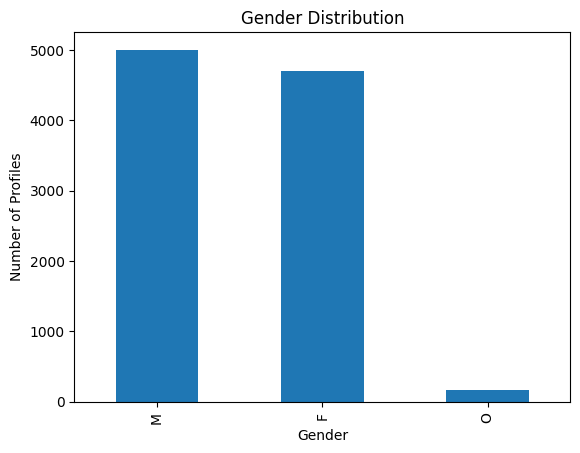

In [10]:
ax = df[df['offer completed']==1].gender.value_counts()
ax.plot(kind='bar')
plt.ylabel('Number of Profiles')
plt.xlabel('Gender')
plt.title('Gender Distribution');

In [11]:
def visualize(x, y, dataset, Xsize, Ysize):
    plt.figure(figsize=(Xsize,Ysize))
    ax = sns.countplot(x=x, hue=y, data=dataset)
    return(ax)

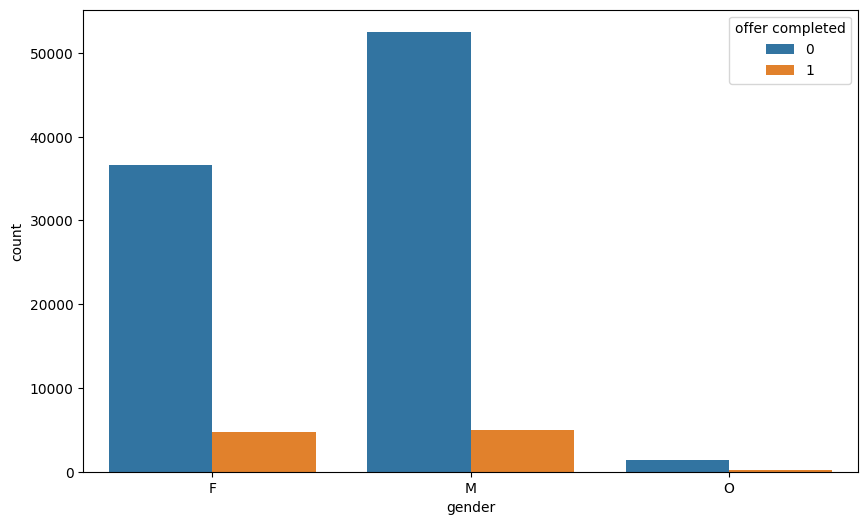

In [12]:
visualize(df['gender'], df['offer completed'], df, 10, 6);

##### 2. What is the proportion of client who have completed the offers based on Age?

In [13]:
df.age.describe()

count    100371.000000
mean         53.645894
std          17.558180
min          18.000000
25%          41.000000
50%          55.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

Before answering Q2 and Q3, we can see that it is more easy to analyse ages and incomes in term of intervals than in term of numbers. To do so, we will add new columns representing the interval that age and income belong to

In [47]:
# We will split the different values of ages into differents intervals so that the analysis will be more easy to analyse
age_range = pd.cut(df['age'],[18,24,30,39,49,59,69,79,111], labels=['18-24','25-30','31-39','40-49','50-59','60-69','70-79','80-111'])
# One-hot encode ages column
ages_dummies = pd.get_dummies(age_range)

df = pd.concat([df, ages_dummies], axis=1, sort=False)
df.drop(["age"], axis=1, inplace=True)

In [48]:
age_cols=['18-24','25-30','31-39','40-49','50-59','60-69','70-79','80-111']
df[df['offer completed']==1][age_cols].sum()

18-24     1337
25-30     1480
31-39     2769
40-49     4859
50-59     8272
60-69     6914
70-79     4052
80-111    2632
dtype: int64

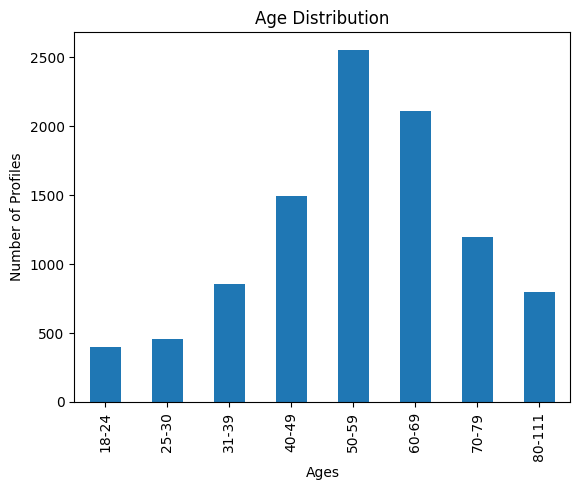

In [16]:
ax = df[df['offer completed']==1][age_cols].sum()
ax.plot(kind='bar')
plt.ylabel('Number of Profiles')
plt.xlabel('Ages')
plt.title('Age Distribution');

Clients' ages are between 18 and 111 but the majority of clients who completed the offer were between 50 and 69 years old

####3. What is the proportion of client who have completed the offers based on their Income Level?


In [17]:
df['income'].describe()

count    100370.000000
mean      64063.614626
std       21233.118681
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       77000.000000
max      120000.000000
Name: income, dtype: float64

In [18]:
# Specifying income range and one hot encoding
income_range = pd.cut(df['income'],[30000, 50000, 70000, 90000, 110000,  130000], labels=['30K-50K','50K-70K','70K-90K','90K-110K','110K-130K'])
income_dummies = pd.get_dummies(income_range)

df = pd.concat([df, income_dummies], axis=1, sort=False)
df.drop(["income"], axis=1, inplace=True)

In [19]:
income_cols=['30K-50K','50K-70K','70K-90K','90K-110K','110K-130K']
df[df['offer completed']==1][income_cols].sum()

30K-50K      1945
50K-70K      3239
70K-90K      2811
90K-110K     1431
110K-130K     413
dtype: int64

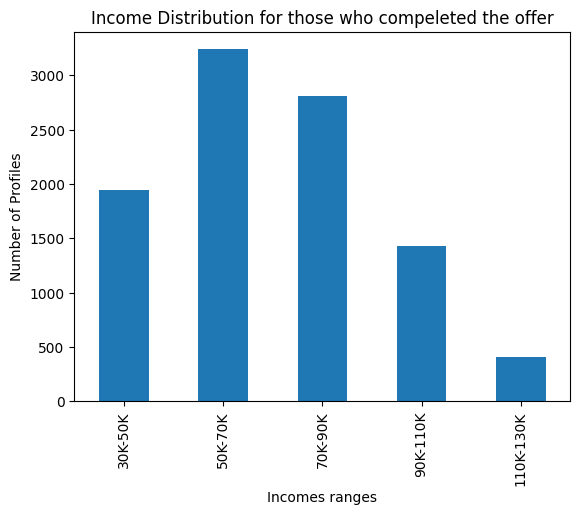

In [20]:
ax = df[df['offer completed']==1][income_cols].sum()
ax.plot(kind='bar')
plt.ylabel('Number of Profiles')
plt.xlabel('Incomes ranges')
plt.title('Income Distribution for those who compeleted the offer');

####4. What is the proportion of client who have completed the offers based on offer type?

In [21]:
df.offer_type.value_counts()

bogo             24437
discount         23671
informational     9321
Name: offer_type, dtype: int64

In [22]:
df[df['offer completed']==1].offer_type.value_counts()

discount    5360
bogo        4807
Name: offer_type, dtype: int64

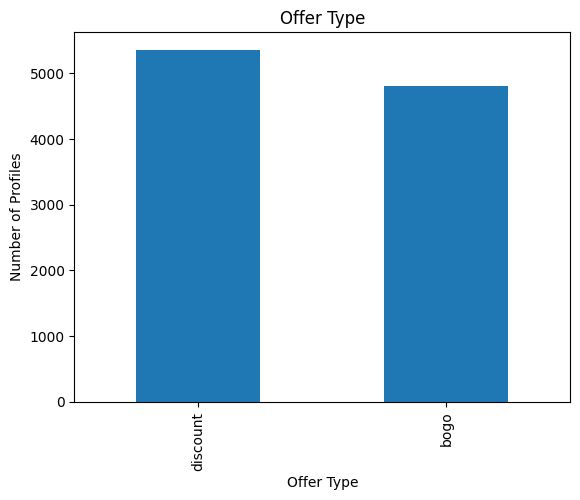

In [23]:
ax = df[df['offer completed']==1].offer_type.value_counts()
ax.plot(kind='bar')
plt.ylabel('Number of Profiles')
plt.xlabel('Offer Type')
plt.title('Offer Type');

In [24]:
dummy_offer = pd.get_dummies(df['offer_type'])
df = pd.concat([df, dummy_offer], axis=1)
df.drop(columns='offer_type',inplace=True)

In [25]:
dummy_gender = pd.get_dummies(df['gender'])
df = pd.concat([df, dummy_gender], axis=1)
df.drop(columns='gender',inplace=True)

# **Data preparation for the Model**

In [26]:
df.columns

Index(['customer_id', 'time', 'offer_id', 'amount', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'difficulty',
       'duration', 'reward', 'email', 'mobile', 'social', 'web',
       'became_member_on', '18-24', '25-30', '31-39', '40-49', '50-59',
       '60-69', '70-79', '80-111', '30K-50K', '50K-70K', '70K-90K', '90K-110K',
       '110K-130K', 'bogo', 'discount', 'informational', 'F', 'M', 'O'],
      dtype='object')

In [27]:
# Since we are interested in offer completion , lets remove other attributes before going on to create a model
df = df.drop(["offer received", 'offer viewed', 'transaction', "became_member_on","customer_id","offer_id"], axis=1)

In [28]:
#We can see that amount_invalid column has missing data. Since it is so 'sparse' for BOGO offers, it might not have much information after all. We assess this feature again later during the model implementation phase. For now, we fill the missing amount_invalid column with 0.
df.isnull().sum()

time                   0
amount             57429
offer completed        0
difficulty         55295
duration           55295
reward             55295
email              55295
mobile             55295
social             55295
web                55295
18-24                  0
25-30                  0
31-39                  0
40-49                  0
50-59                  0
60-69                  0
70-79                  0
80-111                 0
30K-50K                0
50K-70K                0
70K-90K                0
90K-110K               0
110K-130K              0
bogo                   0
discount               0
informational          0
F                      0
M                      0
O                      0
dtype: int64

In [29]:
# fill missing values for amount_invalid with 0
df["amount"].fillna(value=0, inplace = True)
df.dropna(inplace=True)

In [30]:
#define target and feature
X = df.drop(["offer completed"], axis=1) #features
Y = df["offer completed"] #target

Before processing the learning model, first we need to split our data into training and testing datasets. model_pipeline is a function that receives features and target as input and split them into training and testing features and targets

In [31]:
def model_pipeline(features,target):
    '''
    inputs:
    - features & target dataframe 
    
    outputs:
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.20, random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [32]:
#Standardize and split dataset

X_train,X_test,y_train, y_test = model_pipeline(X,Y)

After splitting our data, we feed them to a learning function.

In [33]:
def model_learning(model, X_train, y_train, X_test, y_test):
    '''
    inputs:
       - model: the learning algorithm to be trained
       - X_train: features training set
       - y_train: target training set
       - X_test: features testing set
       - y_test: target testing set for
    
    outputs:
    - the learning model
    - ypred: the predicted values
    '''
    #Fit the learner to the training data
    model = model.fit(X_train,y_train)
    
    predictions_train = model.predict(X_train)
    
    #predictions on the test set
    ypred = model.predict(X_test)
    
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("MSE_train: %.3f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.3f" % mean_squared_error(y_test,ypred))
    print("Training accuracy:%.3f" % model.score(X_train,y_train))
    print("Test accuracy:%.3f" % model.score(X_test,y_test))
    print(classification_report(y_test, ypred,digits=3))
    return ypred

In [ ]:
In our case, we choose 3 models: Radial SVM, Linear regression and Decision Tree Classifier as they are ideal for binary classification tasks.
In the other hand, our data is imbalanced so both accuracy and f1 score are implemented as model evaluation metrics.

**Radial Support Vector Machines(rbf-SVM)**

In [34]:
model = svm.SVC(kernel='rbf',C=1,gamma=0.1)
y_svm = model_learning (model, X_train, y_train, X_test, y_test)

SVC trained on 45943 samples.
MSE_train: 0.177
MSE_test: 0.176
Training accuracy:0.823
Test accuracy:0.824
              precision    recall  f1-score   support

           0      0.825     0.999     0.904      9472
           1      0.125     0.000     0.001      2014

    accuracy                          0.824     11486
   macro avg      0.475     0.500     0.452     11486
weighted avg      0.702     0.824     0.745     11486



**Logistic Regression**

In [36]:
model = LogisticRegression()
ypred_lr = model_learning (model, X_train, y_train, X_test, y_test)

LogisticRegression trained on 45943 samples.
MSE_train: 0.181
MSE_test: 0.179
Training accuracy:0.819
Test accuracy:0.821
              precision    recall  f1-score   support

           0      0.825     0.995     0.902      9472
           1      0.188     0.006     0.012      2014

    accuracy                          0.821     11486
   macro avg      0.506     0.500     0.457     11486
weighted avg      0.713     0.821     0.746     11486



**Decision Tree Classifier**

In [37]:
model = DecisionTreeClassifier()
ypred_dtc = model_learning (model, X_train, y_train, X_test, y_test)

DecisionTreeClassifier trained on 45943 samples.
MSE_train: 0.066
MSE_test: 0.165
Training accuracy:0.934
Test accuracy:0.835
              precision    recall  f1-score   support

           0      0.880     0.927     0.903      9472
           1      0.539     0.404     0.462      2014

    accuracy                          0.835     11486
   macro avg      0.710     0.665     0.682     11486
weighted avg      0.820     0.835     0.825     11486



When comparing the 3 trained models, we notice that all of them give good results but the decision tree model performs better than the two others (Training accuracy:0.934 vs 0.819 and 0.823 for Linear regression and rbf_svm respectively). This motivates us to apply Grid search algorithm to decision tree model to further improve the results 

#### Grid Search to discover optimal parameters

In [38]:
#define Grid Search function
def Decision_Tree_param_selection(X_train ,y_train):
    '''
    input:
    - X_train,y_train: training datasets features and target
    output:
    - dictionary with best parameters for Decision Tree model
    '''
    pipe = Pipeline(steps=[('std_slc',StandardScaler()),
                           ('pca', decomposition.PCA()),
                           ('dec_tree', DecisionTreeClassifier())])

    parameters = dict(pca__n_components=list(range(1,X.shape[1]+1,1)),
                      dec_tree__criterion=['gini', 'entropy'],
                      dec_tree__max_depth=[2,4,6,8,10,12])

    clf_GS = GridSearchCV(pipe, parameters)
    clf_GS.fit(X_train, y_train)
    print(clf_GS.best_params_)
    
    return clf_GS

In [39]:
#best_param_model = Decision_Tree_param_selection(X_train, y_train)
cv = Decision_Tree_param_selection(X_train, y_train)

{'dec_tree__criterion': 'entropy', 'dec_tree__max_depth': 10, 'pca__n_components': 26}


Now that we selected the best parameters leading to best result, we predict again our test set to get prediction values

In [40]:
y_pred_best = cv.predict(X_test)

In [41]:
print("MSE_test: %.3f" % mean_squared_error(y_test,y_pred_best))
print("Test accuracy:%.3f" % (y_pred_best == y_test).mean())
print(classification_report(y_test, y_pred_best,digits=3))

MSE_test: 0.156
Test accuracy:0.844
              precision    recall  f1-score   support

           0      0.896     0.917     0.906      9472
           1      0.561     0.501     0.530      2014

    accuracy                          0.844     11486
   macro avg      0.729     0.709     0.718     11486
weighted avg      0.838     0.844     0.840     11486



After applying the grid search, we remark that the performance is slightly better (Grid Search Test accuracy:0.844 vs Random parameters Test accuracy:0.835)

# **Conclusion**



*   During this Udacity Capstone project from Starbucks data, we worked with 3 data files in form of json that consists on portfolio data, profile data and transcript data.

*   We explored the Starbuck’s Dataset which records how people make purchasing decisions and how those decisions are influenced by promotional offers.(Buy one get one, Discount and informational).


**Our focus during this project was on answering the following questions:**


1.   What is the proportion of client who have completed the offers based on Gender?
2.   What is the proportion of client who have completed the offers based on their Age?
3.   What is the proportion of client who have completed the offers based on their Income Level?
4.   What is the proportion of client who have completed the offers based on offer type?


We began this project by first exploring, cleaning the data, merging the three data before proceeding to find answers to our primarily driven queries.



*   For questions(1-3): we found that "The clients who have completed the offer are male and female. Most clients are in the age range from 29-69 but the big range is between 50-69 years old. Most of the clients who completed their offer have  incomme in the range between 50K- 90K".

*   For (Q4) we found out that most clients who had completed their offer received Discount offer. None of them get Informational offer.


During the ML part, creating a supervised model able to predict effectively if the client will complete his offer was challenging. We choose to apply 3 models(Decision Tree Classifier, Linear regression model and RBF-SVM model).

We compared the performances of these models and found out that Decision Tree Classifier performs better. So we decided to further investigate this model and applied grid search algorithm in order to optimize the obtained results.

Overall, I found this project challenging, mainly due to the structure of the data in the transcript dataset.

# **Further Improvements and Experimentation**

Due to time reasons, I couldn't get a chance to try some other enhancement in the step of model tuning. For example, I can test more ML algorithm so better results can be achieved, also, I can do some more experiment on feature engineering step to see if any other new features can improve the model, espcially in the term of reducing some features to see how it will affect the model performance.
